In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### INTRODUCTION
#### 데이터 선정 이유
- 그동안 데이터를 캐글에서 다운받고 이를 다시 jupyter이나 drive에 옮겨와서 이용하는데에 시간을 너무 많이 썼고, 그래서 항상 모델을 설계하는 것보다 그부분에서 신경을 많이 쓴 것 같다는 점이 아쉬웠다.
- 그러나 나는 모델의 정확도를 높이는 데에 초점을 두고 싶었기 때문에 앞으로 당분간은 데이터 새롭게 고르는데에 신경을 쏟지 않고 편하게 다운이 가능한 ```sklearn.datasets```패키지를 이용해서 가장 기본적인 데이터부터 데이터 전처리, 파이프라인 설계, 다양한 모델로 학습, 결과 도출까지 해보고자 한다.
- 무엇보다 kaggle의 다운로드 API는 ```tf.keras.utils.get_file()```이 불가능하다는 것을 나는 모르고 있었다.

지금 사용하고자 하는 데이터셋은 **lfw_people**이라는 데이터인데, 총 1288개의 얼굴 데이터가 존재하고 이는 촏 7명의 사람의 얼굴이다. 우리는 따라서 이를 맞추는 것을 목표로 한다.

In [8]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, color = True)

In [9]:
data = lfw_people

### 1. Matching People Face With Names

#### 1-1. Data Load
- 이 데이터셋의 데이터 로드 부분이 쉬운 이유는 이미 이미지가 array의 형태로 바뀌어 있기 때문이라고 확신한다.
- 일단 이미지응 jpg/png의 형태에서 array의 형태로 바꾸는 방법이 너무 많아서 힘들었기 때문이다.

**사용했던 이미지 로드 방법을 정리하자면**
1. 우선 directory를 리스트의 형태로
```
root_dir = 저장 경로
path = os.listdir(root_dir)
for i in path:
  img_path = os.path.join(root_dir, i)
```
이런식으로 하위 항목의 파일명을 받아서 합치거나 만약 **csv파일에 이미지 명이 저장되어 있다면 이를 이용**했다.  
또한, **import pathlib**도 했는데
```
import pathlib
rootpath = pathlib.Path('C:\\Users\\이지혜\\Downloads\\182088_408792_bundle_archive\\utkcropped\\utkcropped')
img_path = list(rootpath.glob('*/'))
```
이런 식으로 glob를 이용해서 파일의 하위 항목들까지 저장을 했다.

2. 이제 이미지를 array의 형태로 바꿔야 한다.

  1. import cv2
```
img = cv2.imread(저장 경로, cv2.IMREAD_COLOR)
img = cv2.resize(img, (new_size, new_size))
```

  2. tf.io.read_file
```
img = tf.io.read_file(image_dir)
img = tf.image.decode_jpeg(img, channels = 3)
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize(img, (128, 128))
```
이런 두가지 방법을 사용함으로서 이미지를 array로 바꿔 주었었다.

In [158]:
imgset = lfw_people.images
label = lfw_people.target
real_name = lfw_people.target_names

In [126]:
real_name

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [159]:
imgset.shape

(1288, 62, 47, 3)

In [160]:
imgset[0]

array([[[255., 253., 253.],
        [253., 255., 255.],
        [253., 254., 254.],
        ...,
        [ 69.,  49.,  51.],
        [ 56.,  40.,  44.],
        [ 46.,  32.,  39.]],

       [[254., 253., 255.],
        [254., 253., 255.],
        [254., 251., 254.],
        ...,
        [ 71.,  50.,  53.],
        [ 58.,  40.,  47.],
        [ 48.,  33.,  41.]],

       [[253., 248., 249.],
        [255., 241., 245.],
        [253., 236., 241.],
        ...,
        [ 69.,  48.,  53.],
        [ 57.,  40.,  48.],
        [ 49.,  34.,  44.]],

       ...,

       [[ 92.,  68.,  60.],
        [ 70.,  55.,  49.],
        [ 50.,  36.,  33.],
        ...,
        [133.,  85.,  65.],
        [130.,  82.,  62.],
        [126.,  77.,  57.]],

       [[ 82.,  61.,  54.],
        [ 64.,  49.,  42.],
        [ 47.,  35.,  30.],
        ...,
        [130.,  82.,  60.],
        [130.,  81.,  60.],
        [126.,  76.,  54.]],

       [[ 75.,  56.,  49.],
        [ 62.,  48.,  40.],
        [ 46.,  

In [161]:
real_name

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [167]:
imgset = tf.image.resize(imgset, (128,128))

In [168]:
imgset.shape, label.shape, real_name.shape

(TensorShape([1288, 128, 128, 3]), (1288,), (7,))

- 총 데이터의 개수는 1288개의 이미지 데이터이고, 이미지의 크기는 (62,47)이며 전체 분류가 가능한 class의 개수는 7개이다.
- 따라서 우리는 다중 분류 문제로 분류를 해서 문제를 해결해야 한다.
- 먼저 이미지 특성 인식을 위해서 CNN layer을 이용한 뒤에 심층 신경망을 이용해서 분류를 할 예정이다.
- ImageDataGenerator을 이용해서 이미지 증식을 하고 학습시키기 위한 최적의 학습기를 위해 RandomClassifierCV를 이용할 예정이다.

In [113]:
label[0]

5

[ 724   49  446  550  801  457  294 1149  805]


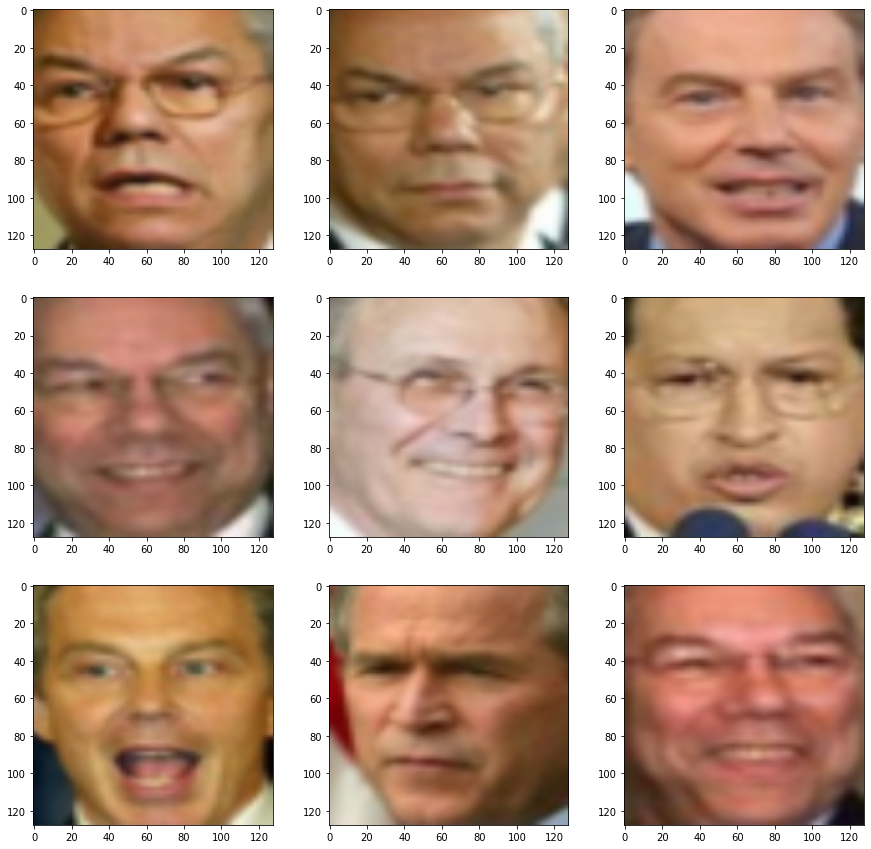

In [163]:
plt.figure(figsize = (15,15))
import random
rand_index = np.random.randint(0,1288,9)
print(rand_index)
for i in range(9):
  plt.subplot(3,3,i+1)
  img = tf.image.resize(imgset[rand_index[i]], (128,128))
  plt.imshow(img/255.0)
  #plt.title(real_name[label[rand_index[i]]])
plt.show()

#### 1-2. Data Augmentation
- label은 1에서 7까지의 값이니까 원핫 인코딩을 진행하는 것과 batch normalization을 진행하는 것중에 선택해야 한다.
- 이미지는 이미지 증식을 위해서 keras의 ImageDataGenerator을 이용할 생각이다.


In [169]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

In [170]:
label = to_categorical(label)

In [171]:
label

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [173]:
from sklearn.model_selection import train_test_split
random_seed = 42
x_train, x_val, x_test = imgset[:927], imgset[927:927+258], imgset[927+258:]

In [174]:
x_train.shape, x_val.shape, x_test.shape

(TensorShape([927, 128, 128, 3]),
 TensorShape([258, 128, 128, 3]),
 TensorShape([103, 128, 128, 3]))

In [175]:
y_train, y_val, y_test = label[:927], label[927:927+258], label[927+258:]

In [176]:
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(
    rescale = 1/255.0,
    featurewise_center = False,
    samplewise_center = False,
    rotation_range = 10,
    width_shift_range = 0.1,
    zoom_range = 0.1,
    height_shift_range = 0.1,
)
test_datagen = ImageDataGenerator(
    rescale = 1/255.0
)
val_datagen = ImageDataGenerator(
    rescale = 1/255.0
)

#### 1-3. Making a Dataset

In [177]:
train_datagen.fit(x_train)

In [178]:
train_dataset = train_datagen.flow(
    x_train, y_train, 
    batch_size  = BATCH_SIZE,
    shuffle = True, 
)
test_dataset = test_datagen.flow(
    x_test, y_test
)
val_dataset = val_datagen.flow(
    x_val, y_val
)

#### 여기서 잠깐 데이터를 다룰 수 있는 다른 방법을 보자면, 단 이때는 저장소가 파일 저장 경로로서 string의 형태로 저장이 되어 있을 떄이다.

In [ ]:
def parse_image(filename):
  parts = tf.strings.split(filename, '/')
  label =parts[-2] == CLASS_NAMES
  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  return image, label

In [ ]:
def augment_image(image, label):
  im_shape = image.shape
  image=tf.image.random_flip_left_right(image)
  image=tf.image.random_flip_up_down(image)
  image=tf.image.rot90(image)
  # image=tf.random.normal(im_shape,mean=0,stddev=0.1)
  # image.set_shape(im_shape)
  return image, tf.cast(label,tf.float32)

In [ ]:
def create_dataset(file_list,shuffle_buffer_size=1000):
  ds=tf.data.Dataset.from_tensor_slices(file_list)
  ds=ds.shuffle(buffer_size=len(file_list))
  ds=ds.map(parse_image,num_parallel_calls=AUTOTUNE)
  ds=ds.map(augment_image,num_parallel_calls=AUTOTUNE)
  ds=ds.repeat()
  ds=ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

#### 1-4. Making a Model

In [179]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, LeakyReLU, MaxPool2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.activations import selu, softmax
adam = tf.keras.optimizers.Adam(0.0002)
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 20, monitor = 'val_accuracy')

In [181]:
model = Sequential()
model.add(Conv2D(128, input_shape = (128, 128, 3), kernel_size = 3, strides = 2, padding = 'same', activation = 'selu'))
model.add(MaxPool2D(pool_size = (2,2), strides = 2, padding = 'valid'))
model.add(Conv2D(256, kernel_size = 2, strides = 2, padding ='same', activation = 'selu'))
model.add(Conv2D(256, kernel_size = 2, strides = 2, padding = 'same', activation = 'selu'))
model.add(MaxPool2D(pool_size = (2,2), strides = 2, padding = 'valid'))
model.add(Flatten())
model.add(Dense(512, activation = 'selu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation = 'selu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation = 'softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 64, 64, 128)       3584      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 256)       131328    
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 8, 256)         262400    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)              

#### 1-5. Training

In [182]:
model.compile(optimizer = adam, metrics = ['accuracy'], loss = 'categorical_crossentropy')

In [183]:
history = model.fit(
    train_dataset, validation_data = val_dataset, steps_per_epoch = x_train.shape[0]//BATCH_SIZE, epochs = 200, callbacks = [early_stopping]
)

Epoch 1/200
28/28 [==============================] - 16s 580ms/step - loss: 2.1204 - accuracy: 0.3140 - val_loss: 1.5886 - val_accuracy: 0.4341
Epoch 2/200
28/28 [==============================] - 16s 574ms/step - loss: 1.7009 - accuracy: 0.3821 - val_loss: 1.5141 - val_accuracy: 0.4535
Epoch 3/200
28/28 [==============================] - 16s 577ms/step - loss: 1.6478 - accuracy: 0.4078 - val_loss: 1.4677 - val_accuracy: 0.4457
Epoch 4/200
28/28 [==============================] - 16s 580ms/step - loss: 1.6016 - accuracy: 0.4201 - val_loss: 1.5019 - val_accuracy: 0.4922
Epoch 5/200
28/28 [==============================] - 16s 578ms/step - loss: 1.5216 - accuracy: 0.4469 - val_loss: 1.3335 - val_accuracy: 0.4612
Epoch 6/200
28/28 [==============================] - 16s 576ms/step - loss: 1.4541 - accuracy: 0.4793 - val_loss: 1.1673 - val_accuracy: 0.5620
Epoch 7/200
28/28 [==============================] - 16s 582ms/step - loss: 1.3846 - accuracy: 0.5050 - val_loss: 1.2035 - val_accuracy:

#### 1-6. Evaluating Results

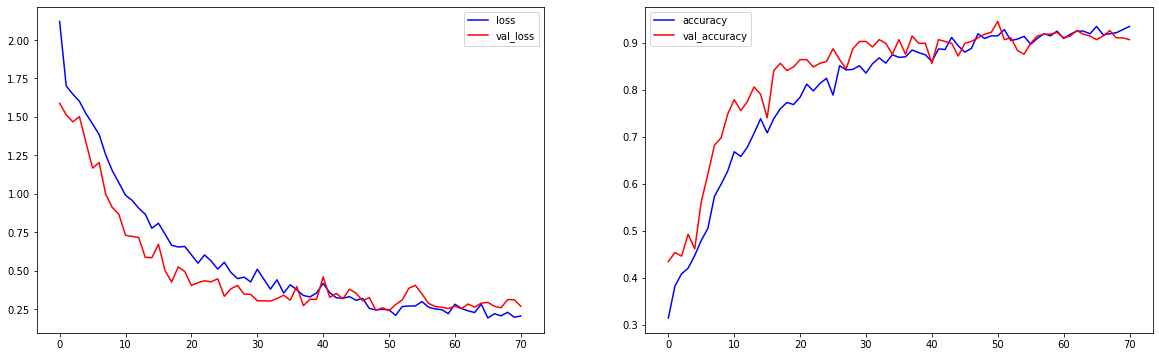

In [227]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label = 'loss')
plt.plot(history.history['val_loss'], 'r-', label = 'val_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'b-', label = 'accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label = 'val_accuracy')
plt.legend()
plt.show()


In [184]:
model.evaluate(test_dataset)

4/4 [==============================] - 0s 69ms/step - loss: 0.1766 - accuracy: 0.9320


[0.17660674452781677, 0.9320388436317444]

### Accuracy = 93.20%

### 2. Matching Pairs of People Face
1. 앞서 이미지와 얼굴 인식이 된 모델을 이용해서 Dense Layer을 추가하여서, 혹은 channel을 바꾸어서 주어지는 두개의 이미지가 같은지 확인하거나 아니면 이어서 이진 분석 모델을 추가하는 방법을 사용하고자 한다.
2. 아니면 처음부터 다시 학습이 가능하겠지만 이는 너무 비효율적이라고 생각한다.
3. 아니면 위의 모델의 성능을 확인하는 느낌으로 받아들여도 될 것 같다.

In [185]:
from sklearn.datasets import fetch_lfw_pairs
lfw_pairs_train = fetch_lfw_pairs(subset = 'train', color = True)

In [186]:
pair_img = lfw_pairs_train.pairs
pair_info = lfw_pairs_train.data
pair_target = lfw_pairs_train.target

In [191]:
pair_img.shape

(2200, 2, 62, 47, 3)

In [192]:
pair_img = pair_img/255.0

In [193]:
pair_target.shape

(2200,)

1


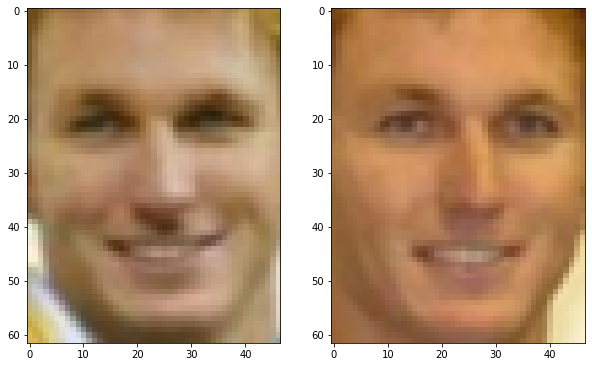

In [47]:
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(pair_img[0][0]/255.0)
plt.subplot(1,2,2)
plt.imshow(pair_img[0][1]/255.0)
print(pair_target[0])

In [197]:
left_img, right_img = pair_img[:,0], pair_img[:,1]

In [200]:
left_img = tf.image.resize(left_img, (128,128))
right_img = tf.image.resize(right_img, (128,128))

In [201]:
left = model.predict(left_img)
right = model.predict(right_img)

In [208]:
tf.argmax(left[0])

<tf.Tensor: shape=(), dtype=int64, numpy=4>

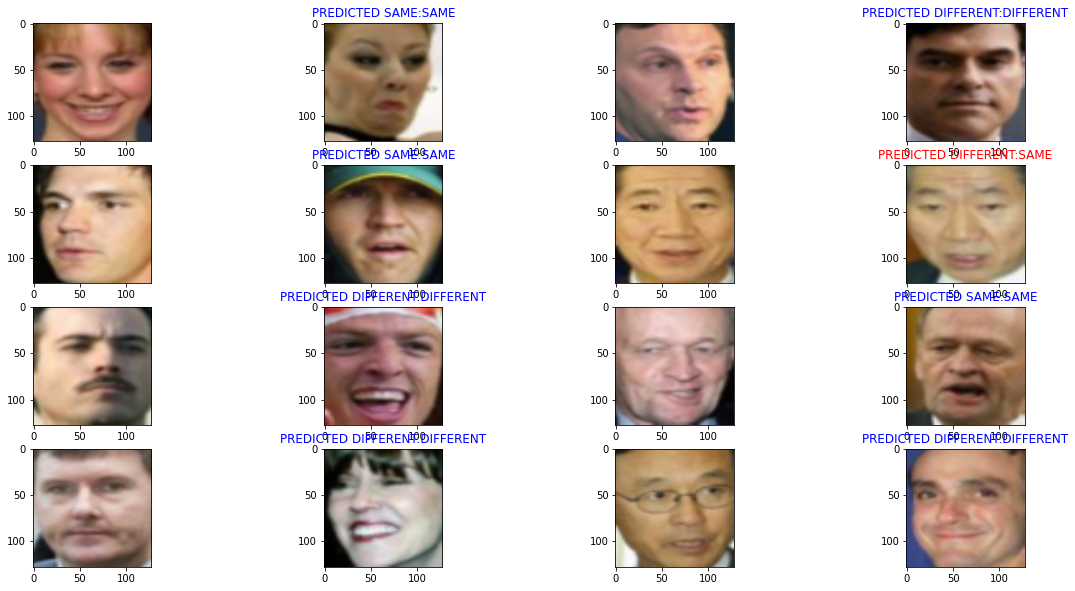

In [220]:
testing_index = np.random.randint(0,2200,8)
plt.figure(figsize = (20,10))
index = 1
for i in range(8):
  k = testing_index[i]
  a,b = tf.argmax(left[k]), tf.argmax(right[k])
  plt.subplot(4,4,index)
  index += 1
  plt.imshow(left_img[k])
  plt.subplot(4,4,index)
  index += 1
  plt.imshow(right_img[k])
  if pair_target[k] == 1:answer = 'SAME'
  else:answer = 'DIFFERENT'
  if a == b:
    if answer == 'SAME':plt.title('{}:{}'.format('PREDICTED SAME', answer), color = 'b')
    else:plt.title('{}:{}'.format('PREDICTED SAME', answer), color = 'r')
  else:
    if answer == 'SAME':plt.title('{}:{}'.format('PREDICTED DIFFERENT', answer), color = 'r')
    else:plt.title('{}:{}'.format('PREDICTED DIFFERENT', answer), color = 'b')
plt.show()

  


**위와 같이 높은 정확도, 낮은 loss가 나왔다. 또한 학습 결과를 pairing된 데이터에 학습 시켰을 때에도 확실하게 높은 예측도를 보인다.**